# PGM : HOMEWORK 3¶
# PIERRE OREISTEIN & QUENTIN DUCHEMIN

# 0 - Information

# 1 - Packages

In [1]:
# Mathematical packages
import numpy as np
from scipy.stats import norm, chi2

# Graphic packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.animation
import seaborn as sns
sns.set()

# Animation packages
from IPython.display import HTML

# 2 - Read Data

In [2]:
def read_data(file_name):
    """This function extracts the data contained in the file 'file_name'."""
    
    # Initialisation of the matrix of coordinates
    X = []
    
    # Read file
    with open(file_name, 'r') as file:
        for line in file:
            
            # Remove unwanted '\n' and extract each element written in line
            line = line.rstrip()
            data = line.split(" ")
            
            # Convert the string as float
            data = list(map(float, data))
            
            # Instantiate
            X.append([data[0], data[1]])
            
    # Convert as an array
    X = np.array(X)
    
    # Return result
    return X

In [3]:
# Import the data
U = read_data('./Data/EMGaussian.data')
U_test = read_data('./Data/EMGaussian.test')

# Display to check if all is alright
U;

# 3 - HMM

In [4]:
def lnp_u_conditionning_to_q(u_t, q_t, mu, cov):
    """Return the value of p(u_t|q_t) for the given u_t and the given q_t."""
    
    # Extract the parameters of the gaussian
    mu_t = mu[q_t, :]
    cov_t = cov[q_t, :, :]

    # Compute the value of the gaussian
    inv = np.linalg.inv(cov_t)
    x = np.dot((u_t - mu_t), np.dot(inv, (u_t - mu_t)))
    
    value = -np.log(2 * np.pi * np.sqrt(np.linalg.det(cov_t))) - 0.5 * x

    return value

In [5]:
def lnalpha_t_plus_1(lnalpha_t, u_t_plus_1, a, mu, cov, K=4):
    """Compute alpha_t_plus_1."""
    
    # Initialize alpha_t_plus_1
    lnalpha_t_plus_1 = np.ones(K)

    # Compute each state of alpha_t_plus_1
    for q_t_plus_1 in range(K):

        # Compute p(u_t+1 | q_t_+1)
        lnp_u_cond_q = lnp_u_conditionning_to_q(u_t_plus_1, q_t_plus_1, mu, cov)

        # Update alpha_t_plus_1
        vec_proba = np.log(a[:, q_t_plus_1])+ lnalpha_t
        maxi = np.max(vec_proba)

        argexp = lnp_u_cond_q +\
                 np.log(np.sum(np.exp(vec_proba - maxi),
                                      dtype=np.longdouble), 
                        dtype=np.longdouble) + maxi
        lnalpha_t_plus_1[q_t_plus_1] = argexp

    return lnalpha_t_plus_1

In [6]:
def lnbeta_t(lnbeta_t_plus_1, u_t_plus_1, a, mu, cov, K=4):
    """Compute alpha_t_plus_1."""
    
    # Initialize beta_t
    lnbeta_t = np.ones(K)
    
    # Compute each state of beta_t
    for q_t in range(K):
        
        vec_proba = np.zeros(K)
        
        for q_t_plus_1 in range(K):
            
            # Compute the log of the product of the probabilities
            vec_proba[q_t_plus_1] = lnp_u_conditionning_to_q(u_t_plus_1, 
                                                                   q_t_plus_1, mu, cov)
            vec_proba[q_t_plus_1] += np.log(a[q_t, q_t_plus_1])
            vec_proba[q_t_plus_1] += lnbeta_t_plus_1[q_t_plus_1]
                
        # Update alpha_t_plus_1
        maxi = np.max(vec_proba)
        argexp = np.log(np.sum(np.exp(vec_proba - maxi,
                                      dtype=np.longdouble)),
                        dtype=np.longdouble) + maxi
        lnbeta_t[q_t] = argexp
        
    return lnbeta_t

In [7]:
def estimation(U, pi, a, mu, cov, K=4):
    """Compute alpha_t and beta_t."""
    
    # Parameters
    T, d = np.shape(U)
    
    # Initialise alpha and beta
    lnalpha = np.ones((T, K))
    lnbeta = np.ones((T, K))
    
    # Initialisation of alpha_0 and beta_T
    for q_0_k in range(K):
        lnalpha[0, q_0_k] = np.log(pi[q_0_k]) #+ lnp_u_conditionning_to_q(U[0,:], q_0_k, mu, cov)
    lnbeta[T - 1, :] = np.zeros(K)
    
    # Computation of alpha
    for t in range(1, T):
        
        # Update of alpha
        lnalpha[t, :] = lnalpha_t_plus_1(lnalpha[t - 1, :], U[t, :], a, mu, cov)
        
    # Computation of beta
    for i in range(2, T + 1):
        
        # t
        t = T - i
        
        # Update of beta
        lnbeta[t, :] = lnbeta_t(lnbeta[t + 1, :], U[t + 1, :], a, mu, cov)
    
    return lnalpha, lnbeta 

In [8]:
def compute_p_q_u(lnalpha, lnbeta):
    """Return log(p(q_t, u_0, ..., u_T))."""
    
    return lnalpha + lnbeta

In [9]:
def compute_p_u(lnalpha, lnbeta):
    """Return log(p(u_0, ..., u_T))."""
    
    # Parameters
    T, K = np.shape(lnalpha)
    
    # Extract max
    arg = (lnalpha + lnbeta)[0,:]
    maxi = np.max(arg)
    
    # Compute the result
    res = np.log(np.sum(np.exp(arg - maxi))) + maxi
    
    return(res)

In [10]:
def compute_q(lnalpha, lnbeta):
    """Return log(p(q_t| u_0, ..., u_T))."""
    
    # Parameters
    T, K = np.shape(lnalpha)
    
    # Compute p(z_t, y_0, ..., y_T)
    lnp_q_u = compute_p_q_u(lnalpha, lnbeta)
    
    # Compute p(y_0, ..., y_T)
    lnp_u = compute_p_u(lnalpha, lnbeta)
    
    return lnp_q_u - lnp_u

In [11]:
def compute_q_q(lnalpha, lnbeta, U, a, mu, cov):
    """Return log(p(q_t, q_t+1 | u_0, ..., u_T))."""
    
    # Parameters
    T, K = np.shape(lnalpha)
    
    # Compute p(y_0, ..., y_T)
    lnp_u = compute_p_u(lnalpha, lnbeta)
    
    # Initialisation of p(z_t, z_t+1 |y)
    lnp_q_q = np.ones((T-1, K, K))
    
    # Compute each value
    for t in range(T-1):
        
        for k in range(K):
            for l in range(K):
                
                # p_u_cond_q
                lnp_u_cond_q = lnp_u_conditionning_to_q(U[t+1, :], l, mu, cov)
                
                # Update p_q_q
                lnp_q_q[t, k, l] = -lnp_u + lnalpha[t, k] + lnbeta[t+1, l] + np.log(a[k,l]) +\
                                   lnp_u_cond_q
    
    return lnp_q_q

In [12]:
def Mstep(U, pi, a, cov, mu, p_q, p_q_q):
    """This function executes the M step of the EM algorithm for general covariance
       matrices."""
    
    # Parameters
    K = len(pi)
    T, d = np.shape(U)
    
    # Estimator of mu_k
    for k in range(K):
        
        mu[k,:] = [0,0]
        
        for t in range(T):
            mu[k,:] += p_q[t, k] * U[t,:]
            
        mu[k,:] /= np.sum(p_q[:,k])
    
    # Estimator of sigma2_k
    for k in range(K):
        
        cov[k,:,:] = np.zeros((d, d))
        
        for t in range(T):
            
            y = (U[t,:] - mu[k,:]).reshape(d, 1)     
            cov[k,:,:] += p_q[t, k] * np.dot(y, y.T)

        cov[k,:,:] /= np.sum(p_q[:,k])
        
        # Regularisation for avoiding null matrices.
        cov[k,:,:] += 0.001 * np.eye(d)
        
    # Estimator of a_k
    a = np.zeros((K, K))
    
    for k in range(K):        
        for l in range(K):
            
            a[k,l] = np.sum(p_q_q[:, k, l])
            
        a[k, :] = a[k, :] / np.sum(p_q_q[:,k,:])
            
    # Estimator of pi_k
    pi = p_q[0, :]
    
    # Return results
    return pi, a, cov, mu

In [13]:
def objectif(U, pi, a, cov, mu, p_q, p_q_q):
    """This function computes the complete-log-likelihood for the given parameters."""
    
    # Parameters
    K = len(pi)
    T, d = np.shape(U)
    
    # Initialisation of the value of the objectif function with the zero term
    objectif = np.sum(pi * p_q[0, :])
    
    # Loop over each data point
    for t in range(T):
        for k in range(K):
            
            # Add the term with a
            if t > 0:
                objectif += np.sum(a[k, :] * p_q_q[t-1, k, :])
            
            # Add the term of the gaussian
            y = U[t,:] - mu[k,:]
            inv = np.linalg.inv(cov[k,:,:])
            
            temp = -0.5 * np.dot(y, np.dot(inv, y))                                                                                      
            temp -= np.log(2 * np.pi * np.sqrt(np.linalg.det(cov[k,:,:])))
            objectif += temp * p_q[t,k]
    
    return objectif

In [14]:
def EM(U, mu, cov, K=4):
    """This function executes the EM algorithm."""
    
    # Parameters
    T, d = np.shape(U)
    
    # Initialisation of a
    a = np.zeros((K, K)) + 1 # np.random.rand(K, K)
    for k in range(K):
        a[k, :] /= np.sum(a[k, :])

    # Initialisation of the parameters for the E step
    pi = np.ones(K) # np.random.rand(K)
    pi /= np.sum(pi)
    
    # Initialisation of the latent probabilities
    p_q_q = np.random.rand(T, K, K)
    for t in range(T):
        p_q_q[t, :, :] /= np.sum(p_q_q[t, :, :])
    
    p_q = np.sum(p_q_q, axis=2)
        
    # Initialisation of the objectif
    objectif_new = objectif(U, pi, a, cov, mu, p_q, p_q_q)
    objectif_old = 2 * objectif_new
    
    # Count the number of iteration
    ite = 0
    
    while abs((objectif_old - objectif_new) / objectif_old) > 10e-6:
        
        # E step
        lnalpha, lnbeta = estimation(U, pi, a, mu, cov, K=K)
        p_q = compute_q(lnalpha, lnbeta)
        p_q = np.exp(p_q)
        p_q_q = compute_q_q(lnalpha, lnbeta, U, a, mu, cov)
        p_q_q = np.exp(p_q_q)
        
        # M step
        pi, a, cov, mu = Mstep(U, pi, a, cov, mu, p_q, p_q_q)
        
        # Update of the objectif
        objectif_old = objectif_new
        objectif_new = objectif(U, pi, a, cov, mu, p_q, p_q_q)
        
        # Increase the counter
        ite += 1
        print("Value of the objective: ",objectif_new)
    
    # Display the numbner of iterations done
    print("Number of iterations done:", ite)
    
    return pi, a, cov, mu, p_q, p_q_q

In [15]:
# Past result for mu, cov
mu_TP2 = np.load("./Data/mu_TP2.npy")
cov_TP2 = np.load("./Data/cov_TP2.npy")
q_TP2 = np.load("./Data/q_TP2.npy")

In [16]:
# Executes the EM on the data
pi, a, cov, mu, p_q, p_q_q = EM(U, mu_TP2, cov_TP2, K=4)

Value of the objective:  -1350.9810523836393
Value of the objective:  -1305.252301882815
Value of the objective:  -1304.2346680712765
Value of the objective:  -1304.1637393972144
Value of the objective:  -1304.1429247557344
Value of the objective:  -1304.1375631362043
Number of iterations done: 6


# 4 - Graphic functions

## 4.1 - Functions

In [34]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    
    
    r2 = chi2.ppf(q, 2)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

In [35]:
def ellipsoides_general(mu, cov, ax):
    """Display 90% of the mass of the gaussian distributions contain in mu and sigma2 """

    # Parameter
    K = len(cov)
    n, d = np.shape(U)
    
    # Clusters
    clusters = [i for i in range(K)]
    
    # Set of colors
    cmap = cm.get_cmap("tab10") #["orange", "red", "green", "blue"]
    colors = np.array([cmap(c) for c in clusters])
    
    # Add the ellipsoide for each gaussian        
    for k in range(K):
        width, height, rotation = cov_ellipse(cov[k,:,:], q=0.9)
        p = patches.Ellipse(xy=(mu[k,0], mu[k,1]),
                            width=width, height=height, angle=rotation, 
                            edgecolor=colors[k],
                            fill=False)
        ax.add_patch(p)

In [36]:
def attribute_clusters(q):
    """Attribute a cluster to each data point contain in gamma."""
    
    return np.argmax(q, axis=1)

In [37]:
def scatter(X, clusters, K, label="Cluster ", s=20, alpha=1, marker="x", edgecolors="none"):
    """This function displays the points (x_i) contains in X.
       It also adapted the color of the point according to the cluster it belongs to."""
    
    # Set of colors
    cmap = cm.get_cmap("tab10") #["orange", "red", "green", "blue"]
    colors = np.array([cmap(c) for c in clusters])
    
    # Display the data for each cluster
    for k in range(K):
        
        # Extract the coordinates and colors
        X_k = X[np.where([clusters == k])[1], :]
        colors_k = colors[np.where([clusters == k])[1]]
        
        # Made the scatter plot
        plt.scatter(x=X_k[:,0], y=X_k[:,1], label=label + str(k), 
                    c=colors_k, alpha=alpha, marker=marker, s=s,
                    edgecolors=edgecolors)

In [38]:
def figure_HMM(U, cov, mu, q, name="HMM"):
    """This functions display the data point, the cluster, and the parameters of
       the gaussians of the latent variables."""
    
    # Parameter
    K = len(cov)
    n, d = np.shape(U)
    
    # Parameters of the figure
    fig, ax = plt.subplots(figsize=(11, 11))
    plt.grid(True)
    
    # Set the axes
    ax.set_xlim(U[:,0].min() - 1, U[:,0].max() + 1)
    ax.set_ylim(U[:,1].min() - 1, U[:,1].max() + 1)
    ax.set_aspect(1.0)
    
    # Attribute a cluster to each data point and display the data
    clusters = attribute_clusters(q)
    scatter(U, clusters, K, alpha=0.6)
    
    # Display the mean of the gaussians
    clusters_mu = np.array([i for i in range(K)])
    scatter(mu, clusters_mu, K, label="Center ", marker="o", s=50,
            edgecolors="black")
    
    #  Display the ellipsoide of each cluster
    ellipsoides_general(mu, cov, ax)

    # Legend of the axes
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    
    # Display the legend
    plt.legend()
    
    # Save the fig
    plt.savefig("./Images/" + name, bbox_inches='tight', pad_inches=0.0)
    
    # Display the figure
    plt.show()

## 4.2 - Dislpay the Result

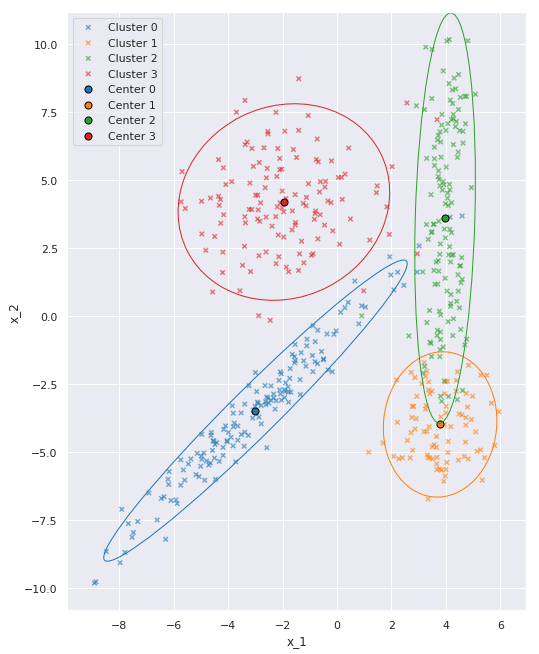

In [39]:
# Display the results
figure_HMM(U, cov, mu, p_q)

# 5 - Points Over Time

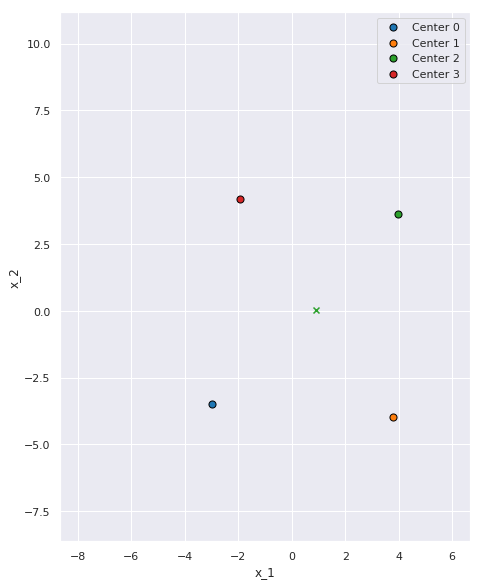

In [40]:
# Parameter
K = len(cov)

# Extract a portion of U
U_display = U[:200, :]

# Parameters of the figure
fig, ax = plt.subplots(figsize=(8, 8))
plt.tight_layout()
plt.grid(True)

# Set the axes
ax.set_xlim(U_display[:,0].min() - 1, U_display[:,0].max() + 1)
ax.set_ylim(U_display[:,1].min() - 1, U_display[:,1].max() + 1)
ax.set_aspect(1.0)

# Legend of the axes
plt.xlabel("x_1")
plt.ylabel("x_2")

# Attribute a cluster to each data point and display the data
clusters = attribute_clusters(p_q)

# Display the mean of the gaussians
clusters_mu = np.array([i for i in range(K)])
scatter(mu, clusters_mu, K, label="Center ", marker="o", s=50,
        edgecolors="black")

# Set of colors
cmap = cm.get_cmap("tab10")
colors = np.array([cmap(c) for c in clusters])

# The graph
scat = ax.scatter([], [], marker="x")

def update(frame_number):
    
    # Update the data
    scat.set_offsets(U_display[:frame_number+1, :])
    
    # Update the colors
    scat.set_color(colors[:frame_number+1])
    
# Make the animation
ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(U_display))

# Display the legend
plt.legend()

# Display the figure
HTML(ani.to_jshtml()); # Need to be remove for showing the JS interface

# 6 - Inference Algorithm

On cherche ici à résoudre le problème de decoding, c'est à dire, trouver q* tel que:
$$ q^* \in \text{argmax}_{q_1, ..., q_T} ~~ p(q_1, ..., q_T ~|~ u_, ..., u_T)$$

Pour résoudre ce problème, on va donc appliquer le Max-Product Algorithm.

## 6.1 - Inference algorithm

In [41]:
def max_lnalpha_t_plus_1(lnalpha_t, u_t_plus_1, a, mu, cov, K=4):
    """Compute alpha_t+1 according to the MPA algorithm and the q_maximising_t+1."""
    
    # Initialize alpha_t_plus_1 and argmax
    lnalpha_t_plus_1 = np.ones(K)
    q_t_maximising_alpha_t_plus_1 = np.zeros(K)

    # Compute each state of alpha_t_plus_1
    for q_t_plus_1 in range(K):

        # Compute p(u_t+1 | q_t_+1)
        lnp_u_cond_q = lnp_u_conditionning_to_q(u_t_plus_1, q_t_plus_1, mu, cov)

        # Computation of the maximum among q_t
        vec_proba = lnp_u_cond_q + np.log(a[:, q_t_plus_1]) + lnalpha_t 
        maxi = np.max(vec_proba)
        
        # Update of alpha_t_plus_1
        lnalpha_t_plus_1[q_t_plus_1] = maxi
        
        # Update of q_t maximising alpha_t+1
        q_t_maximising_alpha_t_plus_1[q_t_plus_1] = np.argmax(vec_proba)

    return lnalpha_t_plus_1, q_t_maximising_alpha_t_plus_1

In [42]:
def MaxProductAlgorithm(U, pi, a, mu, cov, K=4):
    """Compute the argmax of p(q1,...,qT | u1,...,uT)."""
    
    # Parameters
    T, d = np.shape(U)
    
    # Initialise alpha and q_maximising
    lnalpha = np.ones((T, K))
    q_maximising_alpha = np.zeros((T, K), dtype=int)
    
    # Initialisation of alpha_0
    for q_0_k in range(K):
        lnalpha[0, q_0_k] = np.log(pi[q_0_k]) +\
                            lnp_u_conditionning_to_q(U[0,:], q_0_k, mu, cov)
    
    # Computation of alpha_t+1 and q_t maximising alpha_t+1
    for t in range(1, T):
        
        # Computation of alpha_t+1 and q_t maximising alpha_t+1
        lnalpha_t_plus_1,\
        q_t_maximising_alpha_t_plus_1 = max_lnalpha_t_plus_1(lnalpha[t - 1, :], 
                                                             U[t, :], a, mu, cov)
        
        # Update of alpha and q_maximising
        lnalpha[t, :] = lnalpha_t_plus_1
        q_maximising_alpha[t, :] = q_t_maximising_alpha_t_plus_1
        
    # Initialisation of the maximising sequence q_t
    q_max = np.zeros(T, dtype=int)
        
    # Extraction of the maximising state of q_T
    q_max[T-1] = np.argmax(lnalpha[T-1, :])
    
    for t in range(1, T):
        
        # tprime
        t_prime = T - t

        # Update of q_max
        q_max[t_prime - 1] = q_maximising_alpha[t_prime, q_max[t_prime]]
    
    return q_max

In [43]:
# Computation of the maximising sequence
q_max = MaxProductAlgorithm(U, pi, a, mu, cov, K=4)

# Display it
q_max;

## 6.2 - Display the result

In [44]:
def figure_Inference(U, cov, mu, q_max, name="HMM_Decoding"):
    """This functions display the data point, the cluster, and the parameters of
       the gaussians of the latent variables for the decoding problem."""
    
    # Parameter
    K = len(cov)
    n, d = np.shape(U)
    
    # Parameters of the figure
    fig, ax = plt.subplots(figsize=(11, 11))
    plt.grid(True)
    
    # Set the axes
    ax.set_xlim(U[:,0].min() - 1, U[:,0].max() + 1)
    ax.set_ylim(U[:,1].min() - 1, U[:,1].max() + 1)
    ax.set_aspect(1.0)
    
    # Display the data
    clusters = q_max
    scatter(U, clusters, K, alpha=0.6)
    
    # Display the mean of the gaussians
    clusters_mu = np.array([i for i in range(K)])
    scatter(mu, clusters_mu, K, label="Center ", marker="o", s=50,
            edgecolors="black")
    
    #  Display the ellipsoide of each cluster
    ellipsoides_general(mu, cov, ax)

    # Legend of the axes
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    
    # Display the legend
    plt.legend()
    
    # Save the fig
    plt.savefig("./Images/" + name, bbox_inches='tight', pad_inches=0.0)
    
    # Display the figure
    plt.show()

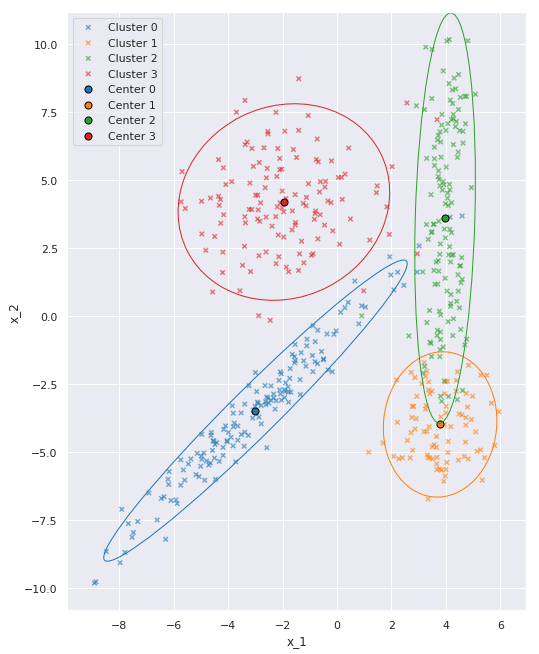

In [45]:
figure_Inference(U, cov, mu, q_max)

In [46]:
# Test of the difference between the result obtain now and for the attribution of the clusters
# by taking the maximum of the marginals
q_test = attribute_clusters(p_q)
print("Number of points classified differently: ", np.sum(np.abs(q_test-q_max)>0))

Number of points classified differently:  0


#  7 - Log-likelihood comparison 

In [47]:
def loglikelihood(X, pi, cov, mu, q):
    """This function computes the complete-log-likelihood for the given parameters
       for a GM model."""
    
    # Parameters
    K = len(pi)
    n, d = np.shape(X)
    
    # Initialisation of the value of the objectif function
    objectif = 0
    
    # Loop over each data point
    for i in range(n):
        for k in range(K):
            
            y = X[i,:] - mu[k,:]
            inv = np.linalg.inv(cov[k,:,:])
            
            objectif -= 0.5 * np.dot(y, np.dot(inv, y))
            objectif -= np.log(2 * np.pi * np.sqrt(np.linalg.det(cov[k,:,:])))
            objectif += np.log(pi[k])
            objectif *= q[i,k]
    
    return objectif

In [48]:
# Compute the log-likelihood for the training dataset
likelihood_train = loglikelihood(U, pi, cov, mu, p_q)

# Compute the log-likelihood for the testing dataset
lnalpha_test, lnbeta_test = estimation(U_test, pi, a, mu, cov, K=K)
p_q_test = compute_q(lnalpha_test, lnbeta_test)
p_q_test = np.exp(p_q_test)
likelihood_test = loglikelihood(U_test, pi, cov, mu, p_q_test)

# Compute the log-likelihood for the training dataset
[obj_train, obj_test,\
 obj_train_iso, obj_test_iso] = np.load("./Data/likelihood_previous_homework.npy")

In [49]:
# Parameters
n, d = np.shape(U)
n_test, d = np.shape(U_test)

# Display the results
print("                          LOG-LIKELIHOOD / Number of data")
print("\n")
print("                                    TRAIN                        TEST")
print("HHM MODEL                     ", likelihood_train / n, "         ", likelihood_test / n_test)
print("PREVIOUS HOMEWORK GENERAL CASE", obj_train / n, "          ", obj_test / n_test)
print("PREVIOUS HOMEWORK ISOTROPIC   ", obj_train_iso / n, "          ", obj_test_iso / n_test)

                          LOG-LIKELIHOOD / Number of data


                                    TRAIN                        TEST
HHM MODEL                      -7.36421445801308e-13           -2.262732376700936e-18
PREVIOUS HOMEWORK GENERAL CASE -1.298853784518237e-05            -9.634074774414793e-10
PREVIOUS HOMEWORK ISOTROPIC    -5.611671381627928e-06            -4.3625507165490404e-12
